# A simple DNN model built in Keras.

Let's start off with the Python imports that we need.

In [82]:
import os, json, math
import numpy as np
import tensorflow as tf
tf.enable_v2_behavior()
print(tf.__version__)

2.0.0-alpha0


## Locating the CSV files

We will start with the CSV files that we wrote out in the [first notebook](../01_explore/taxifare.iypnb) of this sequence. Just so you don't have to run the notebook, we saved a copy in ../data

In [83]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter 126266 Jun  3 15:48 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 593612 Jun  3 15:48 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter 126833 Jun  3 15:48 ../data/taxi-valid.csv


## Use tf.data to read the CSV files

We wrote these cells in the [third notebook](../03_tfdata/input_pipeline.ipynb) of this sequence.

In [84]:
CSV_COLUMNS  = ['fare_amount',  'pickup_datetime',
                'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 
                'passenger_count', 'key']
LABEL_COLUMN = 'fare_amount'
DEFAULTS     = [[0.0],['na'],[0.0],[0.0],[0.0],[0.0],[0.0],['na']]

In [85]:
def features_and_labels(row_data):
    for unwanted_col in ['pickup_datetime', 'key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             .cache())
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

In [86]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

def build_dnn_model():
    INPUT_COLS = ['pickup_longitude', 'pickup_latitude', 
                  'dropoff_longitude', 'dropoff_latitude', 
                  'passenger_count']

    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in INPUT_COLS
    }
    feature_columns = [
        tf.feature_column.numeric_column(colname)
           for colname in INPUT_COLS
    ]
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns)(inputs)

    # two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear')(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

model = build_dnn_model()
print(model.summary())

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_count (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_latitude (InputLayer)    [(None,)]            0                                            
___________________________________________________________________________________________

## Train model

To train the model, call model.fit()

In [87]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('../data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('../data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5
312/312 [==============================] - 5s 17ms/step - loss: 138.5489 - rmse: 10.3084 - mse: 138.5489 - val_loss: 78.9259 - val_rmse: 8.8777 - val_mse: 78.9259
Epoch 2/5
312/312 [==============================] - 5s 15ms/step - loss: 101.8563 - rmse: 9.4159 - mse: 101.8562 - val_loss: 78.8755 - val_rmse: 8.8749 - val_mse: 78.8755
Epoch 3/5
312/312 [==============================] - 5s 15ms/step - loss: 106.1533 - rmse: 9.5837 - mse: 106.1533 - val_loss: 78.7978 - val_rmse: 8.8698 - val_mse: 78.7978
Epoch 4/5
312/312 [==============================] - 5s 15ms/step - loss: 108.5386 - rmse: 9.6634 - mse: 108.5386 - val_loss: 78.6195 - val_rmse: 8.8603 - val_mse: 78.6195
Epoch 5/5
312/312 [==============================] - 5s 15ms/step - loss: 108.7410 - rmse: 9.7277 - mse: 108.7410 - val_loss: 79.7439 - val_rmse: 8.9241 - val_mse: 79.7439


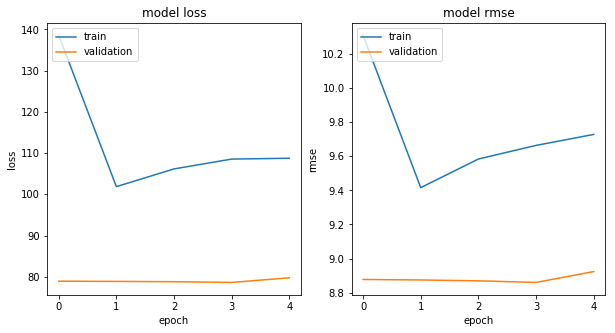

In [88]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Predict with model

This is how you'd predict with this model. 

In [89]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
})

array([[12.271421]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect client code to instantiate the model from that exported file.

## Export model

Let's export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [90]:
# This doesn't work yet.
#tf.keras.experimental.export_saved_model(model, './export/saved_model')


# Recreate the exact same model
new_model = model
#new_model = keras.experimental.load_from_saved_model('./export/saved_model')

# try predicting with this model
new_model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),    
})

array([[12.271421]], dtype=float32)

In the next notebook, we will improve this model through feature engineering.

Copyright 2019 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.